# Packages and variables

In [1]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ sklearn ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
import sklearn
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

# Cross validation
from sklearn.model_selection import cross_val_score, GridSearchCV

# CLassification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier

# Performance
from sklearn.metrics import accuracy_score, balanced_accuracy_score, brier_score_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ Plotly ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
pd.options.plotting.backend = "plotly"
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from plotly.figure_factory import create_table
pio.renderers.default = "notebook_connected" # si dans notebook simple
#pio.renderers.default='colab' # si dans colab 

In [2]:
#Variables

n_estimators = 5

# Datasets & Preprocessing

### Restriction des datasets sur la plus grande plage temporelle commune 

In [ ]:
#preprocessing a potentiellement réimplémenter au besoin 

'''
# Données X
data = pd.read_csv('data.csv', index_col=0)

# Targets format vintages
tp = pd.read_excel("BDD TP Nowcasted.xlsx", index_col=0)
tp.index = tp.index + pd.DateOffset(days=14)
# Conversion des noms de colonnes en datetime
tp.columns = pd.to_datetime(tp.columns)

# Décalage des colonnes au 15 du mois
tp.columns = tp.columns + pd.DateOffset(days=14)
print(tp.shape, len(tp))

# Assurer que les index sont bien des dates
tp.index = pd.to_datetime(tp.index)
data.index = pd.to_datetime(data.index)

# Trouver la plage de dates commune
common_start = max(tp.index.min(), data.index.min())
common_end = min(tp.index.max(), data.index.max())

# Restreindre les deux datasets à cette plage commune
tp = tp.loc[(tp.index >= common_start) & (tp.index <= common_end)]
data = data.loc[(data.index >= common_start) & (data.index <= common_end)]

# Vérification
assert tp.index.equals(data.index), "Les index ne sont pas alignés"
'''


In [10]:
tp = pd.read_csv('tp_croped.csv', index_col=0)
data = pd.read_csv('data_croped.csv', index_col=0)

# Vérification
assert tp.index.equals(data.index), "Les index ne sont pas alignés"

# 1st Modelling : Simple ML

## Modelling

Runtime pour 500 estimateurs = 45mn

In [11]:
# Trouver la dernière ligne non nulle de la première colonne
last_valid_index = tp.iloc[:, 0].last_valid_index()  # Récupère l'index de la dernière valeur non NaN
date_split = tp.index.get_loc(last_valid_index)  # Récupère le numéro de ligne
print(date_split)
range_data_split = range(date_split, len(tp)-1)

#Création de la variable target à partir des vintages
target = pd.DataFrame(np.nan, index=tp.index, columns=['target'])
c=0
for id_split in range_data_split:
    target.loc[target.index[id_split+1], 'target'] = tp.iloc[id_split-1, c+1]
    c+=1

assert target['target'].notna().sum() == len(tp.columns) - 1

#création des dataframes qui stockeront les ouputs
y_test_label_v1 = pd.concat([target, pd.DataFrame(np.nan, index=target.index, columns=['RF_label', 'GB_label'])], axis=1)
y_test_probs_v1 = pd.concat([target, pd.DataFrame(np.nan, index=target.index, columns=['RF_probs', 'GB_probs'])], axis=1)

var_imp_RF_v1 = pd.DataFrame(np.nan, index=data.index, columns=data.columns)
var_imp_GB_v1 = pd.DataFrame(np.nan, index=data.index, columns=data.columns)

344


In [12]:
tp

,2013-09-15,2013-10-15,2013-11-15,2013-12-15,2014-01-15,2014-02-15,2014-03-15,2014-04-15,2014-05-15,2014-06-15,...,2022-03-15,2022-04-15,2022-05-15,2022-06-15,2022-07-15,2022-08-15,2022-09-15,2022-10-15,2022-11-15,2022-12-15
Date,,,,,,,,,,,,,,,,,,,,,
1985-01-15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1985-02-15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1985-03-15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1985-04-15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1985-05-15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1
2022-09-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1
2022-10-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1


In [13]:
data

,S&P 500 COMPOSITE - PRICE INDEX,cmdty BLS Commodity Price Ind 'DEAD' - PRICE INDEX,Gold Bullion LBM $/t oz DELAY,Crude Oil-WTI Spot Cushing U$/BBL,US INITIAL CLAIMS FOR UNEMPLOYMENT INSURANCE (BCI 5) VOLA,US NAHB MARKET SURVEY: NEW SINGLE FAMILY HOME SALES-CURRENTLY,US CONSUMER CONFIDENCE INDEX SADJ,US CONSUMER CONFIDENCE INDEX - EXPECTATIONS SADJ,US CONSUMER CONFIDENCE INDEX - PRESENT SITUATION SADJ,US CONSUMER CONFIDENCE CURRENTLY - JOBS PLENTIFUL SADJ,...,US CONSUMER CONFIDENCE IN 6 MONTHS-PLANS TO BUY VACUUM CLEANER,US CONSUMER CONFIDENCE IN 6 MONTHS-PLANS TO BUY WASHING MACHINE,US NATIONAL ASSOCIATION OF HOME BUILDERS HOUSING MARKET INDEX,US NAHB MARKET SURVEY: NEW SINGLE FAMILY HOME SALES-IN NEXT 6 MO,US NAHB MARKET SURVEY: TRAFFIC OF PROSPECTIVE NEW HOME BUYERS,US ISM PURCHASING MANAGERS INDEX (MFG SURVEY) SADJ,US ISM MANUFACTURERS SURVEY: NEW ORDERS INDEX SADJ,US ISM MANUFACTURERS SURVEY RESULTS: PRICES PAID - SAME VOLN,US ISM MANUFACTURERS SURVEY: PRODUCTION INDEX SADJ,US ISM MANUFACTURERS SURVEY: EMPLOYMENT INDEX SADJ
1985-01-15,179.63,256.90,306.75,26.35,375.0,50.0,102.0,102.5,101.2,19.6,...,5.2,3.8,50.0,59.0,44.0,50.3,51.8,66.0,54.9,44.4
1985-02-15,181.18,251.90,288.75,28.00,388.8,61.0,103.1,103.9,102.0,19.7,...,5.0,3.6,58.0,64.0,48.0,49.9,51.8,75.0,54.2,45.2
1985-03-15,180.66,256.80,330.00,28.30,382.5,56.0,96.1,95.9,96.5,18.2,...,4.6,3.8,54.0,57.0,48.0,47.8,49.1,74.0,51.2,44.2
1985-04-15,179.83,254.10,321.00,27.60,398.3,51.0,104.4,105.1,103.5,19.1,...,4.2,4.5,49.0,56.0,41.0,48.2,51.3,79.0,51.6,43.2
1985-05-15,189.55,246.80,316.00,27.85,393.5,53.0,99.6,99.6,99.6,19.3,...,3.9,3.0,51.0,58.0,42.0,47.1,49.5,76.0,51.9,40.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-15,3955.00,398.56,1719.56,90.05,216.8,57.0,103.6,75.8,145.3,47.6,...,7.8,6.1,49.0,47.0,32.0,53.0,50.5,42.0,51.0,54.2
2022-09-15,3585.62,398.56,1674.06,79.94,197.5,54.0,107.8,79.5,150.2,49.2,...,8.3,5.8,46.0,46.0,31.0,51.1,47.4,41.0,50.9,49.6
2022-10-15,3871.98,398.56,1638.03,86.53,202.5,45.0,102.2,77.9,138.7,44.8,...,8.9,6.5,38.0,35.0,25.0,50.3,49.2,54.0,51.9,50.3
2022-11-15,4080.11,398.56,1751.94,80.45,211.5,39.0,101.4,76.7,138.3,45.2,...,7.7,5.7,33.0,31.0,20.0,49.0,46.4,60.0,51.2,49.3


In [8]:
target

,target
Date,
1985-01-15,NaN
1985-02-15,NaN
1985-03-15,NaN
1985-04-15,NaN
1985-05-15,NaN
...,...
2022-08-15,1.0
2022-09-15,1.0
2022-10-15,1.0


In [14]:
target.isna().sum()

target    345
dtype: int64

In [ ]:


nb_years_lag = 0 # For a recursive window on the training sample (usually 15 years), and 0 for an expanding window

l=0
for id_split in range_data_split:
    #print(l/(len(tp)-1-date_split))


    Y_train_US = tp.iloc[0:id_split+1,l]
    # Y_train_US
    X_train_US = data.iloc[0:id_split+1,:]
    # X_train_US
    
    Y_test_US = tp.iloc[[id_split+1], l+1] #On cherche à prévoir le mois d'après avec l'entièreté des vintages dispos ce mois ci.
    # Y_test_US
    X_test_US = data.iloc[[id_split+1], :]
    # X_test_US

    l += 1
    
    
    model_forest = RandomForestClassifier(n_estimators= n_estimators, random_state=42).fit(X_train_US, Y_train_US)
    var_imp_RF_v1.iloc[id_split+1,:] = model_forest.feature_importances_*100
    # predict label for the next obs only
    y_test_label_v1.loc[y_test_label_v1.index[id_split+1], 'RF_label'] = model_forest.predict(X_test_US)[0]
    # predict probabilities for the next obs [0] only and keep prediction for class 1 [1] only
    y_test_probs_v1.loc[y_test_probs_v1.index[id_split+1], 'RF_probs'] = model_forest.predict_proba(X_test_US)[0][1]

    model_gb = GradientBoostingClassifier(n_estimators= n_estimators, learning_rate=0.1, random_state=42).fit(X_train_US, Y_train_US)
    var_imp_GB_v1.iloc[id_split+1,:] = model_gb.feature_importances_*100
    # predict label for the next obs only
    y_test_label_v1.loc[y_test_label_v1.index[id_split+1], 'GB_label'] = model_gb.predict(X_test_US)[0]
    # predict probabilities for the next obs only and keep prediction for class 1 only
    y_test_probs_v1.loc[y_test_probs_v1.index[id_split+1], 'GB_probs'] = model_gb.predict_proba(X_test_US)[0][1]

## Results

In [7]:
y_label = y_test_label_v1.iloc[date_split + 1:, 0]
y_label_RF = y_test_label_v1.iloc[date_split + 1:,1]
y_label_GB = y_test_label_v1.iloc[date_split + 1:,2]

y_probs_RF = y_test_probs_v1.iloc[date_split + 1:, 1]
y_probs_GB = y_test_probs_v1.iloc[date_split + 1:, 2]

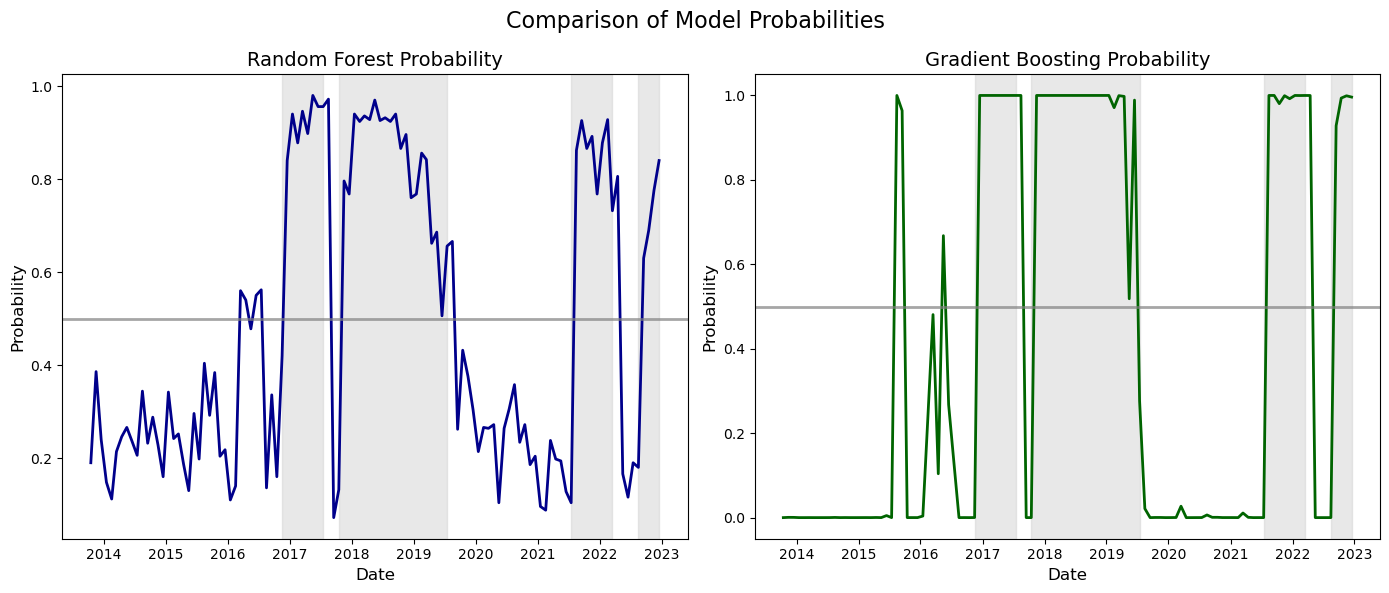

In [8]:
# Créer un subplot avec 1 ligne et 2 colonnes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graphique pour RandomForest
ax1.plot(y_probs_RF.index, y_probs_RF, color='darkblue', lw=2)
threshold = 0.5
ax1.axhline(threshold, color='gray', lw=2, alpha=0.7)
ax1.fill_between(y_label.index, 0, 1, where=y_label == 1,
                 color='lightgray', alpha=0.5, transform=ax1.get_xaxis_transform())
ax1.set_title("Random Forest Probability", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Probability", fontsize=12)

# Graphique pour Gradient Boosting
ax2.plot(y_probs_GB.index, y_probs_GB, color='darkgreen', lw=2)
ax2.axhline(threshold, color='gray', lw=2, alpha=0.7)
ax2.fill_between(y_label.index, 0, 1, where=y_label == 1,
                 color='lightgray', alpha=0.5, transform=ax2.get_xaxis_transform())
ax2.set_title("Gradient Boosting Probability", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Probability", fontsize=12)

# Ajouter un titre général à la figure
fig.suptitle("Comparison of Model Probabilities", fontsize=16)

# Espacement entre les subplots
plt.tight_layout()

# Afficher les graphiques
plt.show()


Text(0, 0.5, 'Probability')

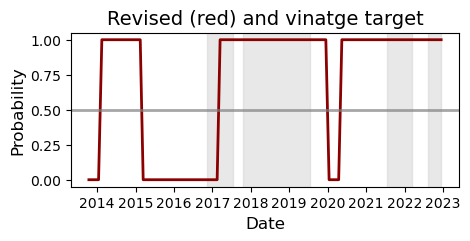

In [9]:
#Juste par curiosité : 

y_label_revised = tp.iloc[date_split + 1:,-1]

fig, ax = plt.subplots(figsize=(5,2))
ax.plot(y_probs_RF.index, y_label_revised, color='darkred', lw=2)

threshold = 0.5
ax.axhline(threshold, color='gray', lw=2, alpha=0.7)
ax.fill_between(y_label.index, 0, 1, where = y_label == 1,
                color='lightgray', alpha=0.5, transform=ax.get_xaxis_transform())
ax.set_title("Revised (red) and vinatge target", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)


In [10]:
print("The Area under the curve for the 1-step ahead prediction based on RF on the out-of-sample is equal to {:.4f}\n".format(roc_auc_score(y_label, y_label_RF)))
print("The Brier score for the 1-step ahead prediction based on RF on the out-of-sample is equal to {:.4f}\n".format(brier_score_loss(y_label, y_probs_RF)))
print("The Accuracy for the 1-step ahead prediction based on RF on the out-of-sample is equal to {:.4f}\n".format(accuracy_score(y_label, y_label_RF)))

print("The Area under the curve for the 1-step ahead prediction based on GB on the out-of-sample is equal to {:.4f}\n".format(roc_auc_score(y_label, y_label_GB)))
print("The Brier score for the 1-step ahead prediction based on GB on the out-of-sample is equal to {:.4f}\n".format(brier_score_loss(y_label, y_probs_GB)))
print("The Accuracy for the 1-step ahead prediction based on GB on the out-of-sample is equal to {:.4f}\n".format(accuracy_score(y_label, y_label_GB)))

The Area under the curve for the 1-step ahead prediction based on RF on the out-of-sample is equal to 0.9025

The Brier score for the 1-step ahead prediction based on RF on the out-of-sample is equal to 0.0991

The Accuracy for the 1-step ahead prediction based on RF on the out-of-sample is equal to 0.9009

The Area under the curve for the 1-step ahead prediction based on GB on the out-of-sample is equal to 0.9066

The Brier score for the 1-step ahead prediction based on GB on the out-of-sample is equal to 0.0859

The Accuracy for the 1-step ahead prediction based on GB on the out-of-sample is equal to 0.9099



In [11]:
def show_confusion_matrix(Y_target, Y_predict):
    # Visualisation de la réussite des prévisions
    confusion_df = pd.DataFrame(confusion_matrix(Y_target,Y_predict),
                              index=["Slowdown","Acceleration"],
                              columns=["Predicted slowdown","Predicted Acceleration"])

    fig = create_table(confusion_df,index=True)

    fig.update_layout(autosize=False,width=450,height=75)

    fig.show()

In [12]:
show_confusion_matrix(y_label,y_label_RF)

In [13]:
show_confusion_matrix(y_label,y_label_GB)

In [14]:
Aggregate_var_imp_RF_v1 = pd.DataFrame(np.nansum(var_imp_RF_v1, axis=0).T, index = data.columns, columns = ['Importance'])
Aggregate_var_imp_RF_v1.index.name = 'variables'
print(Aggregate_var_imp_RF_v1.sort_values(by="Importance", ascending=False).head(10))

                                                    Importance
variables                                                     
US ISM PURCHASING MANAGERS INDEX (MFG SURVEY) SADJ  961.585302
US ISM MANUFACTURERS SURVEY: PRODUCTION INDEX SADJ  838.931723
US ISM MANUFACTURERS SURVEY: NEW ORDERS INDEX SADJ  810.128045
cmdty BLS Commodity Price Ind 'DEAD' - PRICE INDEX  470.547733
US ISM MANUFACTURERS SURVEY: EMPLOYMENT INDEX SADJ  443.978526
US INITIAL CLAIMS FOR UNEMPLOYMENT INSURANCE (B...  385.140595
US CONSUMER CONFIDENCE CURRENTLY - JOBS PLENTIF...  337.384785
S&P 500 COMPOSITE - PRICE INDEX                     331.970513
US NAHB MARKET SURVEY: NEW SINGLE FAMILY HOME S...  288.992509
US CONSUMER CONFIDENCE CURRENTLY - JOBS HARD TO...  287.984382


In [15]:
Aggregate_var_imp_GB_v1 = pd.DataFrame(np.nansum(var_imp_GB_v1, axis=0).T, index = data.columns, columns = ['Importance'])
Aggregate_var_imp_GB_v1.index.name = 'variables'
print(Aggregate_var_imp_GB_v1.sort_values(by="Importance", ascending=False).head(10))

                                                     Importance
variables                                                      
US ISM PURCHASING MANAGERS INDEX (MFG SURVEY) SADJ  2499.441453
cmdty BLS Commodity Price Ind 'DEAD' - PRICE INDEX   900.940234
US INITIAL CLAIMS FOR UNEMPLOYMENT INSURANCE (B...   797.081011
S&P 500 COMPOSITE - PRICE INDEX                      666.591737
US ISM MANUFACTURERS SURVEY: NEW ORDERS INDEX SADJ   603.148745
US CONSUMER CONFIDENCE CURRENTLY - JOBS HARD TO...   573.998394
US ISM MANUFACTURERS SURVEY: PRODUCTION INDEX SADJ   518.657870
US CONSUMER CONFIDENCE CURRENTLY - JOBS PLENTIF...   317.433076
US NAHB MARKET SURVEY: NEW SINGLE FAMILY HOME S...   311.810928
US CONSUMER CONFIDENCE IN 6 MONTHS-BUSINESS CON...   310.926045


# 2nd Modelling : Differentiate variables

## Modelling

In [16]:
#Unused so far
data_lag = data

max_lag = 18
for id_shift in range(1,max_lag+1):
    data_temp = data.shift(id_shift)
    data_temp.rename(columns=lambda s: s + "_lag_" + str(id_shift), inplace=True)
    data_lag = pd.concat([data_lag, data_temp], axis=1)

data_diff = data

max_lag = 18
for id_shift in range(1,max_lag+1):
    data_temp = data.diff(id_shift) # = BDD_data_X - BDD_data_X.shift(id_shift)
    data_temp.rename(columns=lambda s: s + "_diff_" + str(id_shift), inplace=True)
    data_diff = pd.concat([data_diff, data_temp], axis=1)

print(data.shape[1],data_lag.shape[1], data_diff.shape[1])

49 931 931


In [17]:
assert date_split > max_lag

In [18]:
# Trouver la dernière ligne non nulle de la première colonne
last_valid_index = tp.iloc[:, 0].last_valid_index()  # Récupère l'index de la dernière valeur non NaN
date_split = tp.index.get_loc(last_valid_index)  # Récupère le numéro de ligne
print(date_split)
range_data_split = range(date_split, len(tp)-1)

#création des dataframes qui stockeront les ouputs
y_test_label_v2 = pd.concat([target, pd.DataFrame(np.nan, index=target.index, columns=['RF_label', 'GB_label'])], axis=1)
y_test_probs_v2 = pd.concat([target, pd.DataFrame(np.nan, index=target.index, columns=['RF_probs', 'GB_probs'])], axis=1)

var_imp_RF_v2 = pd.DataFrame(np.nan, index=data.index, columns=data_diff.columns)
var_imp_GB_v2 = pd.DataFrame(np.nan, index=data.index, columns=data_diff.columns)

344


In [19]:


nb_years_lag = 0 # For a recursive window on the training sample (usually 15 years), and 0 for an expanding window

l=0
for id_split in range_data_split:
    print(l/(len(tp)-1-date_split))

    if nb_years_lag == 0:
        Y_train_US = tp.iloc[max_lag:id_split+1,l]
        # Y_train_US
        X_train_US = data_diff.iloc[max_lag:id_split+1,:]
        # X_train_US
    else:
        Y_train_US = tp.iloc[id_split-12*nb_years_lag:id_split+1,l] #Ca marchera pas au début à cause des nans dans les variables lag
        # Y_train_US
        X_train_US = data_diff.iloc[id_split-12*nb_years_lag:id_split+1,:]
        # X_train_US    

    Y_test_US = tp.iloc[[id_split+1], l+1] #On cherche à prévoir le mois d'après avec l'entièreté des vintages dispos ce mois ci.
    # Y_test_US
    X_test_US = data_diff.iloc[[id_split+1], :]
    # X_test_US

    l += 1
    
    
    model_forest = RandomForestClassifier(n_estimators= n_estimators, random_state=42).fit(X_train_US, Y_train_US)
    var_imp_RF_v2.iloc[id_split+1,:] = model_forest.feature_importances_*100
    # predict label for the next obs only
    y_test_label_v2.loc[y_test_label_v2.index[id_split+1], 'RF_label'] = model_forest.predict(X_test_US)[0]
    # predict probabilities for the next obs [0] only and keep prediction for class 1 [1] only
    y_test_probs_v2.loc[y_test_probs_v2.index[id_split+1], 'RF_probs'] = model_forest.predict_proba(X_test_US)[0][1]

    model_gb = GradientBoostingClassifier(n_estimators= n_estimators, learning_rate=0.1, random_state=42).fit(X_train_US, Y_train_US)
    var_imp_GB_v2.iloc[id_split+1,:] = model_gb.feature_importances_*100
    # predict label for the next obs only
    y_test_label_v2.loc[y_test_label_v2.index[id_split+1], 'GB_label'] = model_gb.predict(X_test_US)[0]
    # predict probabilities for the next obs only and keep prediction for class 1 only
    y_test_probs_v2.loc[y_test_probs_v2.index[id_split+1], 'GB_probs'] = model_gb.predict_proba(X_test_US)[0][1]

0.0
0.009009009009009009
0.018018018018018018
0.02702702702702703
0.036036036036036036
0.04504504504504504
0.05405405405405406
0.06306306306306306
0.07207207207207207
0.08108108108108109
0.09009009009009009
0.0990990990990991
0.10810810810810811
0.11711711711711711
0.12612612612612611
0.13513513513513514
0.14414414414414414
0.15315315315315314
0.16216216216216217
0.17117117117117117
0.18018018018018017
0.1891891891891892
0.1981981981981982
0.2072072072072072
0.21621621621621623
0.22522522522522523
0.23423423423423423
0.24324324324324326
0.25225225225225223
0.26126126126126126
0.2702702702702703
0.27927927927927926
0.2882882882882883
0.2972972972972973
0.3063063063063063
0.3153153153153153
0.32432432432432434
0.3333333333333333
0.34234234234234234
0.35135135135135137
0.36036036036036034
0.36936936936936937
0.3783783783783784
0.38738738738738737
0.3963963963963964
0.40540540540540543
0.4144144144144144
0.42342342342342343
0.43243243243243246
0.44144144144144143
0.45045045045045046
0.4594

## Results

In [20]:
y_label = y_test_label_v2.iloc[date_split + 1:, 0]
y_label_RF = y_test_label_v2.iloc[date_split + 1:,1]
y_label_GB = y_test_label_v2.iloc[date_split + 1:,2]

y_probs_RF = y_test_probs_v2.iloc[date_split + 1:, 1]
y_probs_GB = y_test_probs_v2.iloc[date_split + 1:, 2]

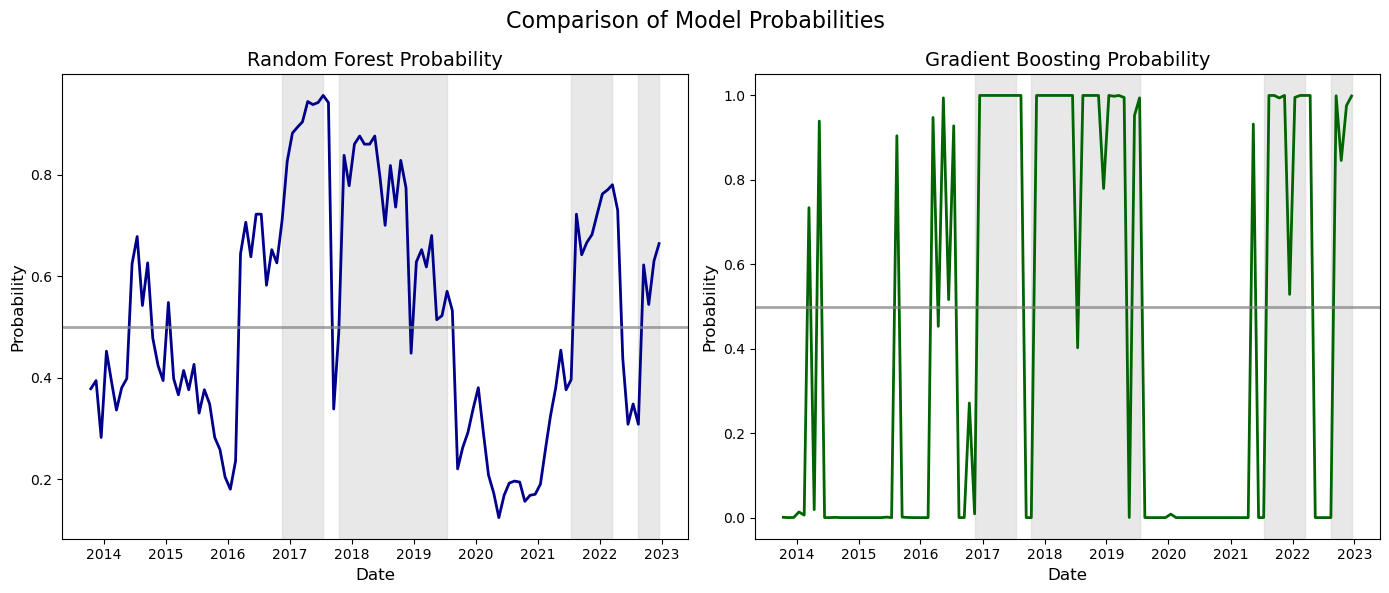

The Area under the curve for the 1-step ahead prediction based on RF on the out-of-sample is equal to 0.8343

The Brier score for the 1-step ahead prediction based on RF on the out-of-sample is equal to 0.1508

The Accuracy for the 1-step ahead prediction based on RF on the out-of-sample is equal to 0.8198

The Area under the curve for the 1-step ahead prediction based on GB on the out-of-sample is equal to 0.8576

The Brier score for the 1-step ahead prediction based on GB on the out-of-sample is equal to 0.1265

The Accuracy for the 1-step ahead prediction based on GB on the out-of-sample is equal to 0.8559



In [21]:
# Créer un subplot avec 1 ligne et 2 colonnes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graphique pour RandomForest
ax1.plot(y_probs_RF.index, y_probs_RF, color='darkblue', lw=2)
threshold = 0.5
ax1.axhline(threshold, color='gray', lw=2, alpha=0.7)
ax1.fill_between(y_label.index, 0, 1, where=y_label == 1,
                 color='lightgray', alpha=0.5, transform=ax1.get_xaxis_transform())
ax1.set_title("Random Forest Probability", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Probability", fontsize=12)

# Graphique pour Gradient Boosting
ax2.plot(y_probs_GB.index, y_probs_GB, color='darkgreen', lw=2)
ax2.axhline(threshold, color='gray', lw=2, alpha=0.7)
ax2.fill_between(y_label.index, 0, 1, where=y_label == 1,
                 color='lightgray', alpha=0.5, transform=ax2.get_xaxis_transform())
ax2.set_title("Gradient Boosting Probability", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Probability", fontsize=12)

# Ajouter un titre général à la figure
fig.suptitle("Comparison of Model Probabilities", fontsize=16)

# Espacement entre les subplots
plt.tight_layout()

# Afficher les graphiques
plt.show()

print("The Area under the curve for the 1-step ahead prediction based on RF on the out-of-sample is equal to {:.4f}\n".format(roc_auc_score(y_label, y_label_RF)))
print("The Brier score for the 1-step ahead prediction based on RF on the out-of-sample is equal to {:.4f}\n".format(brier_score_loss(y_label, y_probs_RF)))
print("The Accuracy for the 1-step ahead prediction based on RF on the out-of-sample is equal to {:.4f}\n".format(accuracy_score(y_label, y_label_RF)))

print("The Area under the curve for the 1-step ahead prediction based on GB on the out-of-sample is equal to {:.4f}\n".format(roc_auc_score(y_label, y_label_GB)))
print("The Brier score for the 1-step ahead prediction based on GB on the out-of-sample is equal to {:.4f}\n".format(brier_score_loss(y_label, y_probs_GB)))
print("The Accuracy for the 1-step ahead prediction based on GB on the out-of-sample is equal to {:.4f}\n".format(accuracy_score(y_label, y_label_GB)))

In [22]:
show_confusion_matrix(y_label,y_label_RF)

In [23]:
show_confusion_matrix(y_label,y_label_GB)

In [24]:
Aggregate_var_imp_RF_v1 = pd.DataFrame(np.nansum(var_imp_RF_v1, axis=0).T, index = data.columns, columns = ['Importance'])
Aggregate_var_imp_RF_v1.index.name = 'variables'
print(Aggregate_var_imp_RF_v1.sort_values(by="Importance", ascending=False).head(10))

                                                    Importance
variables                                                     
US ISM PURCHASING MANAGERS INDEX (MFG SURVEY) SADJ  961.585302
US ISM MANUFACTURERS SURVEY: PRODUCTION INDEX SADJ  838.931723
US ISM MANUFACTURERS SURVEY: NEW ORDERS INDEX SADJ  810.128045
cmdty BLS Commodity Price Ind 'DEAD' - PRICE INDEX  470.547733
US ISM MANUFACTURERS SURVEY: EMPLOYMENT INDEX SADJ  443.978526
US INITIAL CLAIMS FOR UNEMPLOYMENT INSURANCE (B...  385.140595
US CONSUMER CONFIDENCE CURRENTLY - JOBS PLENTIF...  337.384785
S&P 500 COMPOSITE - PRICE INDEX                     331.970513
US NAHB MARKET SURVEY: NEW SINGLE FAMILY HOME S...  288.992509
US CONSUMER CONFIDENCE CURRENTLY - JOBS HARD TO...  287.984382


In [25]:
Aggregate_var_imp_GB_v1 = pd.DataFrame(np.nansum(var_imp_GB_v1, axis=0).T, index = data.columns, columns = ['Importance'])
Aggregate_var_imp_GB_v1.index.name = 'variables'
print(Aggregate_var_imp_GB_v1.sort_values(by="Importance", ascending=False).head(10))

                                                     Importance
variables                                                      
US ISM PURCHASING MANAGERS INDEX (MFG SURVEY) SADJ  2499.441453
cmdty BLS Commodity Price Ind 'DEAD' - PRICE INDEX   900.940234
US INITIAL CLAIMS FOR UNEMPLOYMENT INSURANCE (B...   797.081011
S&P 500 COMPOSITE - PRICE INDEX                      666.591737
US ISM MANUFACTURERS SURVEY: NEW ORDERS INDEX SADJ   603.148745
US CONSUMER CONFIDENCE CURRENTLY - JOBS HARD TO...   573.998394
US ISM MANUFACTURERS SURVEY: PRODUCTION INDEX SADJ   518.657870
US CONSUMER CONFIDENCE CURRENTLY - JOBS PLENTIF...   317.433076
US NAHB MARKET SURVEY: NEW SINGLE FAMILY HOME S...   311.810928
US CONSUMER CONFIDENCE IN 6 MONTHS-BUSINESS CON...   310.926045


# 3rd Modelling : Cross Validation and diff

In [26]:
# Trouver la dernière ligne non nulle de la première colonne
last_valid_index = tp.iloc[:, 0].last_valid_index()  # Récupère l'index de la dernière valeur non NaN
date_split = tp.index.get_loc(last_valid_index)  # Récupère le numéro de ligne
print(date_split)
range_data_split = range(date_split, len(tp)-1)

#création des dataframes qui stockeront les ouputs
y_test_label_v3 = pd.concat([target, pd.DataFrame(np.nan, index=target.index, columns=['RF_label', 'GB_label'])], axis=1)
y_test_probs_v3 = pd.concat([target, pd.DataFrame(np.nan, index=target.index, columns=['RF_probs', 'GB_probs'])], axis=1)

var_imp_RF_v3 = pd.DataFrame(np.nan, index=data.index, columns=data_diff.columns)
var_imp_GB_v3 = pd.DataFrame(np.nan, index=data.index, columns=data_diff.columns)

344


In [27]:
l=0
for id_split in range_data_split:
    print(l/(len(tp)-1-date_split))

    Y_train_US = tp.iloc[max_lag:id_split+1,l]
    X_train_US = data_diff.iloc[max_lag:id_split+1,:]
    Y_test_US = tp.iloc[[id_split+1], l+1] #On cherche à prévoir le mois d'après avec l'entièreté des vintages dispos ce mois ci
    X_test_US = data_diff.iloc[[id_split+1], :]
    

    l += 1
    
    params_grid_forest = {'max_depth':[None] + list(range(4,8,2)),#The maximum depth of the tree.
                          'min_samples_split':range(2, 6, 2), # [2, 4, 6] #The minimum number of samples required to split an internal node
                          'n_estimators':[100, 200]} #Number of classifiers (decision trees here)
    grid_search_cv_forest = GridSearchCV(RandomForestClassifier(random_state=42), params_grid_forest, scoring="accuracy", cv=5)
    model_forest = grid_search_cv_forest.fit(X_train_US, Y_train_US)

    print(model_forest.best_estimator_)

    var_imp_RF_v3.iloc[id_split+1,:] = model_forest.best_estimator_.feature_importances_*100
    # predict label for the next obs only
    y_test_label_v3.loc[y_test_label_v3.index[id_split+1], 'RF_label'] = model_forest.best_estimator_.predict(X_test_US)[0]
    # predict probabilities for the next obs [0] only and keep prediction for class 1 [1] only
    y_test_probs_v3.loc[y_test_probs_v3.index[id_split+1], 'RF_probs'] = model_forest.best_estimator_.predict_proba(X_test_US)[0][1]

    ################################################################################################################################

     #learning Rate value : 0.2, 0.1, 0.001, 0.0001, if above too high, meaning than we use only few classification trees
    params_grid_gb = {'learning_rate':[0.1], #Learning rate shrinks the contribution of each tree by learning_rate.
                          'min_samples_split':range(2,6,2), # [2, 4, 6] #The minimum number of samples required to split an internal node
                          'n_estimators':[10]} #Number of classifiers (decision trees here)
    grid_search_cv_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), params_grid_gb, scoring="accuracy", cv=5)
    model_gb = grid_search_cv_gb.fit(X_train_US, Y_train_US)

    print(model_gb.best_estimator_)

    var_imp_GB_v3.iloc[id_split+1,:] = model_gb.best_estimator_.feature_importances_*100
    # predict label for the next obs only
    y_test_label_v3.loc[y_test_label_v3.index[id_split+1], 'GB_label'] = model_gb.best_estimator_.predict(X_test_US)[0]
    # predict probabilities for the next obs only and keep prediction for class 1 only
    y_test_probs_v3.loc[y_test_probs_v3.index[id_split+1], 'GB_probs'] = model_gb.best_estimator_.predict_proba(X_test_US)[0][1]

0.0
RandomForestClassifier(max_depth=6, random_state=42)
GradientBoostingClassifier(n_estimators=10, random_state=42)
0.009009009009009009
RandomForestClassifier(min_samples_split=4, n_estimators=200, random_state=42)
GradientBoostingClassifier(n_estimators=10, random_state=42)
0.018018018018018018
RandomForestClassifier(max_depth=6, min_samples_split=4, n_estimators=200,
                       random_state=42)
GradientBoostingClassifier(n_estimators=10, random_state=42)
0.02702702702702703
RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)
GradientBoostingClassifier(n_estimators=10, random_state=42)
0.036036036036036036
RandomForestClassifier(max_depth=6, min_samples_split=4, n_estimators=200,
                       random_state=42)
GradientBoostingClassifier(min_samples_split=4, n_estimators=10,
                           random_state=42)
0.04504504504504504
RandomForestClassifier(max_depth=4, random_state=42)
GradientBoostingClassifier(min_samples_split=4, n_esti

In [28]:
print("Feature importances shape:", model_forest.best_estimator_.feature_importances_.shape)
print("var_imp_RF_v3 shape:", var_imp_RF_v3.shape)


Feature importances shape: (931,)
var_imp_RF_v3 shape: (456, 931)


## Results

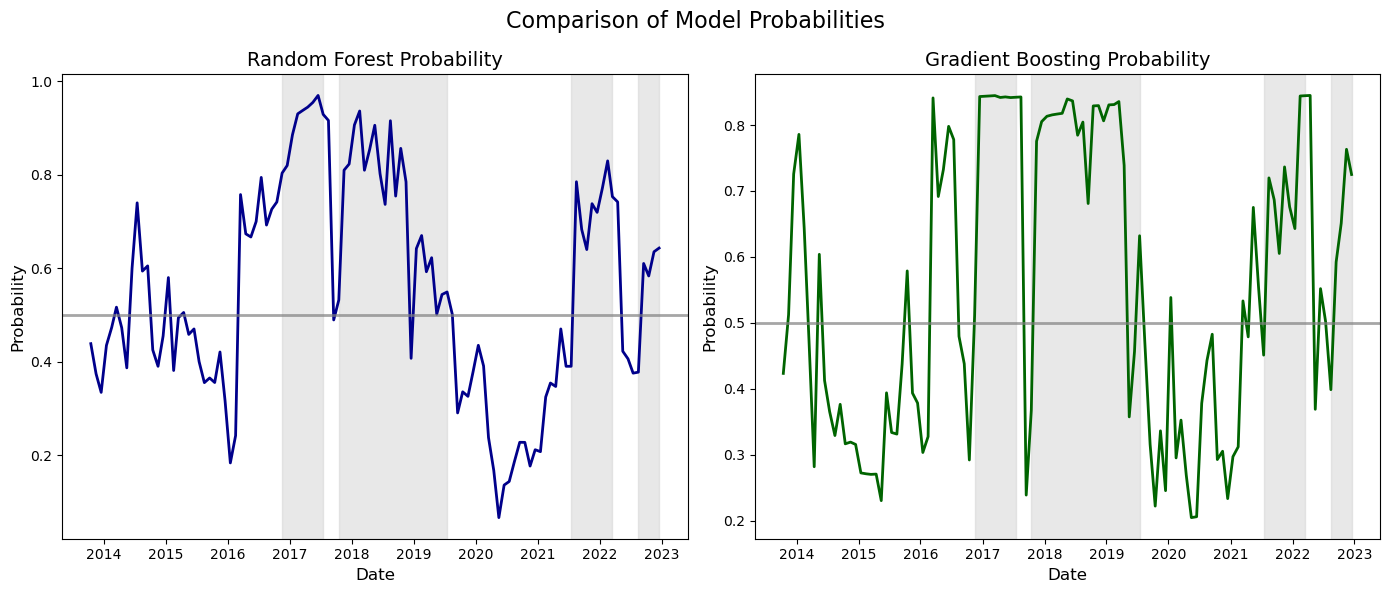

In [29]:
y_label = y_test_label_v3.iloc[date_split + 1:, 0]
y_label_RF = y_test_label_v3.iloc[date_split + 1:,1]
y_label_GB = y_test_label_v3.iloc[date_split + 1:,2]

y_probs_RF = y_test_probs_v3.iloc[date_split + 1:, 1]
y_probs_GB = y_test_probs_v3.iloc[date_split + 1:, 2]


# Créer un subplot avec 1 ligne et 2 colonnes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Graphique pour RandomForest
ax1.plot(y_probs_RF.index, y_probs_RF, color='darkblue', lw=2)
threshold = 0.5
ax1.axhline(threshold, color='gray', lw=2, alpha=0.7)
ax1.fill_between(y_label.index, 0, 1, where=y_label == 1,
                 color='lightgray', alpha=0.5, transform=ax1.get_xaxis_transform())
ax1.set_title("Random Forest Probability", fontsize=14)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Probability", fontsize=12)

# Graphique pour Gradient Boosting
ax2.plot(y_probs_GB.index, y_probs_GB, color='darkgreen', lw=2)
ax2.axhline(threshold, color='gray', lw=2, alpha=0.7)
ax2.fill_between(y_label.index, 0, 1, where=y_label == 1,
                 color='lightgray', alpha=0.5, transform=ax2.get_xaxis_transform())
ax2.set_title("Gradient Boosting Probability", fontsize=14)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Probability", fontsize=12)

# Ajouter un titre général à la figure
fig.suptitle("Comparison of Model Probabilities", fontsize=16)

# Espacement entre les subplots
plt.tight_layout()

# Afficher les graphiques
plt.show()

In [30]:
show_confusion_matrix(y_label,y_label_RF)

In [31]:
show_confusion_matrix(y_label,y_label_GB)

    1. Construire la target et plot les résultats : oui
    2. Ajouter les lags : oui
    3. Grid search CV : en cours
    4. Clean le code, ajouter pipeline et normalization, ajouter un adaboost pourquoi pas, aggréger les résultats des différents modèles (comment ? plus grosse proba ?)
    5. S'attaquer au code des stagios

In [32]:
C

NameError: name 'C' is not defined